# Recommendations Systems
## Final Project: Matrix Factorization Techniques for Context Aware Recommendation

**By:**  

Yarden Shoham, 206561367
<br>
Ido Hadanny, 034537969

<br><br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ALPHA = 0.9

In [ ]:
#RESTART/CONTINUE/USE_EXISTING
HYPERPARAMS_SEARCH="RESTART"


**Prerequisites**

In [ ]:
!pip install --quiet zipfile36

**Imports**

In [ ]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [ ]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [ ]:
random.seed(123)

In [ ]:
df_ratings_train = pd.read_csv('drive/MyDrive/Colab Notebooks/yahoo_movies/ydata-ymovies-user-movie-ratings-train-v1_0.txt', delimiter='\t',
            names = ['user_id', 'movie_id', 'rating', 'converted_rating'])



In [ ]:
df_ratings_test = pd.read_csv('drive/MyDrive/Colab Notebooks/yahoo_movies/ydata-ymovies-user-movie-ratings-test-v1_0.txt', delimiter='\t',
            names = ['user_id', 'movie_id', 'rating', 'converted_rating'])



In [ ]:
df_ratings_test = pd.merge(df_ratings_test, df_ratings_train[['user_id', 'movie_id']], on = ['user_id', 'movie_id'], how='left', indicator=True)
df_ratings_test = df_ratings_test[df_ratings_test._merge == 'left_only']

In [ ]:
len(df_ratings_train), len(df_ratings_test)

(211231, 10133)

In [ ]:
len(set(df_ratings_test.user_id.unique())), len(set(df_ratings_test.movie_id.unique()))

(2309, 2379)

In [ ]:
len(set(df_ratings_test.user_id.unique()) & set(df_ratings_train.user_id.unique())), len(set(df_ratings_test.movie_id.unique()) & set(df_ratings_train.movie_id.unique()))

(2309, 2379)

In [ ]:
df_ratings_train.user_id.nunique(), df_ratings_test.user_id.nunique(), df_ratings_train.movie_id.nunique(), df_ratings_test.movie_id.nunique()

(7642, 2309, 11916, 2379)

In [ ]:
df_demo = pd.read_csv('drive/MyDrive/Colab Notebooks/yahoo_movies/ydata-ymovies-user-demographics-v1_0.txt', delimiter='\t',
            names = ['user_id', 'birthyear', 'gender'])


In [ ]:
df_demo.user_id.nunique()

7642

adding the "c" context variable, as described in https://www.researchgate.net/publication/221141005_Context-based_splitting_of_item_ratings_in_collaborative_filtering


In [ ]:
df_demo['c'] = np.random.randint(0, 2, df_demo.shape[0])

In [ ]:
df_demo.head()

,user_id,birthyear,gender,c
0,1,1979,f,0
1,2,1987,m,0
2,3,1988,f,0
3,4,1983,m,1
4,5,1988,m,0


### Matrix:

In [ ]:
def apply_context(df):
  df1 = df.merge(df_demo, on = 'user_id')
  df1['context_matters'] = (np.random.rand(df1.shape[0]) < ALPHA).astype(int)
  df1['final_rating'] = df1.converted_rating + df1.context_matters * (df1.c * 2 - 1)
  df1['final_rating'] = df1.final_rating.apply(lambda x: max(1, min(5, x)))
  return df1

In [ ]:
df_ratings_train = apply_context(df_ratings_train)
df_ratings_test = apply_context(df_ratings_test)

In [ ]:
ratings = df_ratings_train.pivot(index = 'user_id', columns ='movie_id', values = 'final_rating').fillna(0)
ratings.head()

movie_id,0,1800011850,1800012991,1800013563,1800014841,1800015027,1800018548,1800018575,1800018578,1800018591,1800018600,1800018611,1800018620,1800018623,1800018632,1800018639,1800018653,1800018654,1800018659,1800018665,1800018669,1800018676,1800018697,1800018701,1800018707,1800018710,1800018720,1800018722,1800018727,1800018732,1800018733,1800018737,1800018745,1800018746,1800018755,1800018761,1800018762,1800018783,1800018796,1800018802,...,1808516159,1808516160,1808516172,1808516185,1808516189,1808516203,1808516206,1808516208,1808516212,1808516215,1808516216,1808516225,1808516226,1808516227,1808516245,1808516258,1808516293,1808516297,1808516303,1808516310,1808516319,1808516326,1808516332,1808516334,1808516337,1808516340,1808516350,1808517704,1808517740,1808517753,1808517769,1808517843,1808517861,1808517863,1808518549,1808518669,1808519269,1808519348,1808519428,1808520834
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ratings.shape

(7642, 11916)

**Explore ratings data:**

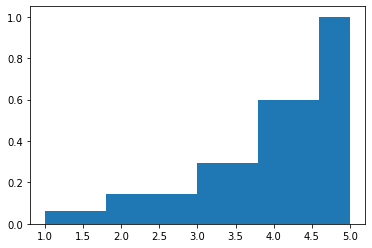

In [ ]:
plt.hist(df_ratings_train.final_rating, cumulative=True, density=True)
plt.show()

according to the histogram, the cutoff between bad and good should be at 4

In [ ]:
class my_metrics():
    
    def RMSE(df_true,df_pred,lower_bound=1,upper_bound=5,debug=False):
        n = (df_true > 0).sum().sum()
        if debug:
          print("n =", n)
        return np.sqrt(((df_true[df_true > 0] - df_pred[df_true > 0])**2).sum().sum() / n)

    def MAE(df_true,df_pred,lower_bound=1,upper_bound=5,debug=False):
        n = (df_true > 0).sum().sum()
        if debug:
          print("n =", n)
        return (abs(df_true[df_true > 0] - df_pred[df_true > 0])).sum().sum() / n

    def MRR(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5,debug=False,cutoff=4):
        mrr = 0
        df_true = df_true[df_true.T.sum() > 0]
        if debug:
          print(f"evaluating for {len(df_true)} active users")
        for idx, user_true in df_true.iterrows():
            user_pred = df_pred.loc[idx]
            mrr += my_metrics.MRR_for_user(user_true, user_pred, lower_bound, upper_bound, top_n, debug and idx % 100 == 1, cutoff)
            if debug and idx % 100 == 1:
              print("idx =", idx, "mrr =", mrr)
        return mrr / len(df_true)
    
    def MRR_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5,debug=False, cutoff=4):
        user_true, user_pred = user_true[user_true > 0], user_pred[user_true > 0] # take only movies the user has seen
        top_n = min(top_n, len(user_true)) # users in folds might have less than 5 items
        top_preds = user_pred.nlargest(top_n)
        top_true = user_true[top_preds.index]
        is_relevant = top_true.where(top_true > cutoff).reset_index(drop=True) # reset the index to 0,1,2...
        k = is_relevant.first_valid_index()
        if debug:          
          display(top_preds.reset_index(name="top_preds").join(
              pd.DataFrame({"top_true": top_true.reset_index(drop=True), 
                        "is_relevant": is_relevant})))
          print("k =", k)
        user_mrr = 0 if k is None else 1/(k + 1)
        return user_mrr
    
    def NDCG(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5,debug=False):      
        dcg = 0
        df_true = df_true[df_true.T.sum() > 0]
        if debug:
          print(f"evaluating for {len(df_true)} active users")
        for idx, user_true in df_true.iterrows():
            user_pred = df_pred.loc[idx]
            dcg += my_metrics.NDCG_for_user(user_true, user_pred, lower_bound, upper_bound, top_n)
        return dcg / len(df_true)
        
    def NDCG_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5,debug=False):
        user_true, user_pred = user_true[user_true > 0], user_pred[user_true > 0] # take only movies the user has seen
        top_n = min(top_n, len(user_true)) # users in folds might have less than 5 items
        top_preds = user_pred.nlargest(top_n)
        top_true = user_true[top_preds.index]
        dcg_series, dcg = my_metrics.DCG(top_true, top_n)
        ideal = user_true.nlargest(top_n)
        idcg_series, idcg = my_metrics.DCG(ideal, top_n)
        if debug:
          print("DCG")
          display(top_preds.reset_index(name="top_preds").join(
              pd.DataFrame({"top_true": top_true.reset_index(drop=True), 
                        "dcg": dcg_series.reset_index(drop=True)})))
          print("IDCG")
          display(ideal.reset_index(name="ideal").join(
              pd.DataFrame({ 
                        "idcg": idcg_series.reset_index(drop=True)})))
          print("dcg =", dcg, "idcg =", idcg)          
        return dcg/idcg
    
    def DCG(rel,n):
        i = np.arange(1, n+1) 
        dcg_series = (2**rel - 1) / np.log2(i+1) # element-wise div
        return dcg_series, np.sum(dcg_series) 
    
    def get_error(df_true,df_pred):        
        return {'RMSE':my_metrics.RMSE(df_true,df_pred,), 'MAE':my_metrics.MAE(df_true,df_pred,) , 'MRR_5':my_metrics.MRR(df_true,df_pred,top_n=5),'MRR_10':my_metrics.MRR(df_true,df_pred,top_n=10),'NDCG_5':my_metrics.NDCG(df_true,df_pred,top_n=5),'NDCG_10':my_metrics.NDCG(df_true,df_pred,top_n=10)}


**Save final results**

In [ ]:
final_results = pd.DataFrame(columns=['Method','Time','RMSE', 'MAE', 'MRR_5','MRR_10','NDCG_5','NDCG_10'])

In [ ]:
df_ratings_train.c.sum(), df_ratings_test.c.sum()

(105800, 5097)

In [ ]:
context_train = df_ratings_train.pivot(index = 'user_id', columns ='movie_id', values = 'c').fillna(0)
context_test = df_ratings_test.pivot(index = 'user_id', columns ='movie_id', values = 'c').fillna(0)

In [ ]:
def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test
train,test = getfulldf(ratings, df_ratings_test.pivot(index = 'user_id', columns ='movie_id', values = 'final_rating').fillna(0))
train.shape,test.shape

((7642, 11916), (7642, 11916))

In [ ]:
context_train, context_test = getfulldf(context_train, context_test)

In [ ]:
df_context = context_train + context_test

In [ ]:
df_context.sum().sum(), context_train.sum().sum(), context_test.sum().sum()

(110897.0, 105800.0, 5097.0)

### Popularity model

Recommend the most popular movies which have more then 10 ratings.

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [ ]:
class POP():

    def __init__(self,df_train,M=10):
    # df is the set to train on
    # N is the number of movies to recommend
    # M is the minimum votes required to be listed in the chart
        self.df_train = df_train
        self.min_movie_ratings = M
        self.recommended = ratings.copy()
        self.recommended[:] = 0
        self.fit_time = 0

    def fit(self):
        start = time.time()
        real_train = self.df_train[self.df_train > 0]
        self.average = (real_train.sum() / real_train.count())
        self.average.loc[real_train.count() < 10] = 0
        self.recommended[:] = 0
        self.recommended += self.average
        self.popular = self.average.sort_values(ascending=False)
        self.fit_time = time.time() - start

    def predict(self,N=10):
        return self.popular.index[:N]
        
    def get_rmse(self,test):
        return my_metrics.RMSE(test, self.recommended)

    def get_mae(self,test):
        return my_metrics.MAE(test, self.recommended)

    def get_mrr(self,test,k=10,threshold=3,debug=False):
        return my_metrics.MRR(test, self.recommended, top_n=k, cutoff=threshold,debug=debug)
        
    def get_ndcg(self,test,k=5,debug=False):
        return my_metrics.NDCG(test, self.recommended, top_n=k,debug=debug)
    

Checking your model and performance:

In [ ]:

# create popularity model
model_pop = POP(train)

# train model
model_pop.fit()


In [ ]:
# record model results
final_results.loc[len(final_results)] = 'Popularity', model_pop.fit_time, model_pop.get_rmse(test), model_pop.get_mae(test), model_pop.get_mrr(test,k=5), model_pop.get_mrr(test,k=10), model_pop.get_ndcg(test,k=5), model_pop.get_ndcg(test,k=10)

# display
final_results

,Method,Time,RMSE,MAE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,3.360194,2.07337,1.492618,0.77561,0.775787,0.958131,0.964912


### Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.   

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [ ]:
class MF():
    
    def __init__(self,df_train,df_context,n_factors=10,only_bias=False,context_aware=True,
                 non_zero_indices=None, test_non_zero_indices=None):
        self.df_train = df_train
        self.df_context = df_context
        self.n_factors = n_factors
        self.only_bias = only_bias
        self.context_aware = context_aware
        
        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape
        
        # biases
        self.original_bias_global = np.sum(df_train.values)/np.count_nonzero(df_train)
        self.original_bias_rows   = np.sum(df_train,axis=1)/np.count_nonzero(df_train,axis=1) 
        self.original_bias_cols   = np.sum(df_train,axis=0)/np.count_nonzero(df_train,axis=0)
        
        self.rows_indices = np.arange(self.n_rows)
        self.cols_indices = np.arange(self.n_cols)
        self.non_zero_indices = []
        self.test_non_zero_indices = []
        if non_zero_indices is not None:
          for idx, row in non_zero_indices[['user_id', 'movie_id']].iterrows():
            u = self.df_train.index.get_loc(row['user_id'])
            i = self.df_train.columns.get_loc(row['movie_id'])
            self.non_zero_indices.append((u, i))
          for idx, row in test_non_zero_indices[['user_id', 'movie_id']].iterrows():
            u = self.df_train.index.get_loc(row['user_id'])
            i = self.df_train.columns.get_loc(row['movie_id'])
            self.test_non_zero_indices.append((u, i))          
        # perf optimization
        else:
          for u in self.rows_indices:
            for i in self.cols_indices:
              if self.df_train.values[u,i] == 0:
                continue
              self.non_zero_indices.append((u,i))
        print('non_zero_indices', len(self.non_zero_indices))
        # "reset" initialization 
        self.initilize_params()
        
        
    def initilize_params(self):
        if self.only_bias:
          self.vecs_rows = np.zeros(shape=(self.n_rows, self.n_factors))
          self.vecs_cols = np.zeros(shape=(self.n_cols, self.n_factors))        
        else:
          self.vecs_rows = np.random.normal(scale=1./self.n_factors,\
                                            size=(self.n_rows, self.n_factors))
          self.vecs_cols = np.random.normal(scale=1./self.n_factors,
                                            size=(self.n_cols, self.n_factors))
        if self.context_aware:
          # we support a single context var with 2 possible values, no unknown
          self.context_vars = np.random.normal(scale=1./self.n_factors,
                                              size=(self.n_cols, 2))
        else:
          self.context_vars = np.zeros(shape=(self.n_cols, 2))
        self.recommended = ratings.copy()
        self.recommended[:] = 0
        # initilize bias
        self.bias_global = self.original_bias_global   # no need to learn it
        self.bias_rows   = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_rows)) # random
        self.bias_cols   = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_cols)) # random
            
        
    def fit(self,
            n_iterations=1,
            learning_rate=1e-1,
            regularization=1e-2,
            convergence=1e-5,
            error='RMSE',
            initilize_training=True,
            verbose=True,
            batch_size = 5):
        
        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
        self.batch_size = batch_size

        if initilize_training:
            self.initilize_params()

           
        # please record your progress in history
        self.history = []
                  
        # please record the training time in fit_time
        start = time.time()

        # please use the class functions 
        # for example(!) :
        if verbose:
          print(f"training on {len(self.non_zero_indices)} non zero indices")
        for current_iteration in range(self.n_iterations):
            
            # None ?
            self.recommended[:] = self.predict_all()
            self.history.append(self.get_rmse(self.df_train))
            
            # printing
            if verbose:
                print('iteration: ',current_iteration,' total error:\n',self.history[-1])
            
            # convergence
            if current_iteration>1 and self.converging():
                
                if verbose:
                    print('converged...')
                break
            self.training_indices = np.arange(len(self.non_zero_indices))
            np.random.shuffle(self.training_indices)
            self.optim_GD()
        self.recommended[:] = self.predict_all()
        self.fit_time = time.time() - start
    
    def converging(self):
        return abs(self.history[-2] - self.history[-1]) < self.ϵ

                  
    def optim_GD(self):        
        delta_vecs_rows, delta_bias_rows, \
          delta_vecs_cols, delta_bias_cols, delta_context_vars = self.zero_grads()
        n_in_batch = 0
        for s_idx, s in enumerate(self.training_indices):
            if n_in_batch == self.batch_size or (s_idx == len(self.training_indices) - 1 and n_in_batch > 0):
              delta_vecs_rows /= n_in_batch
              delta_bias_rows /= n_in_batch
              delta_vecs_cols /= n_in_batch
              delta_bias_cols /= n_in_batch
              delta_context_vars /= n_in_batch
              self.step_rows(delta_vecs_rows, delta_bias_rows)
              self.step_cols(delta_vecs_cols, delta_bias_cols)
              self.step_context_vars(delta_context_vars)
              delta_vecs_rows, delta_bias_rows, \
                delta_vecs_cols, delta_bias_cols, delta_context_vars = self.zero_grads()
              n_in_batch = 0
            n_in_batch += 1
            u, i = self.non_zero_indices[s]
            e = self.df_train.values[u,i] - self.predict_single(u, i) # error
            if not self.only_bias:
              delta_vecs_rows[u, :] += self.α * \
                                      (e * self.vecs_cols[i, :] - \
                                        self.λ * self.vecs_rows[u,:])
              delta_vecs_cols[i, :] += self.α * \
                                      (e * self.vecs_rows[u, :] - \
                                        self.λ * self.vecs_cols[i,:])
            if self.context_aware:
              c = int(self.df_context.values[u,i])
              delta_context_vars[i, c] += self.α * \
                                      (e - self.λ * self.context_vars[i, c])
            
            # Update biases
            delta_bias_rows[u] += self.α * \
                                (e - self.λ * self.bias_rows[u])
            delta_bias_cols[i] += self.α * \
                                (e - self.λ * self.bias_cols[i])

    def zero_grads(self):
        delta_vecs_rows = np.zeros(shape=(self.n_rows, self.n_factors))
        delta_vecs_cols = np.zeros(shape=(self.n_cols, self.n_factors))
        delta_bias_rows = np.zeros(shape=(self.n_rows))
        delta_bias_cols = np.zeros(shape=(self.n_cols))
        delta_context_vars = np.zeros(shape=(self.n_cols, 2))
        return delta_vecs_rows, delta_bias_rows, \
                delta_vecs_cols, delta_bias_cols, delta_context_vars

    def step_rows(self, delta_vecs_rows, delta_bias_rows):
        self.vecs_rows += delta_vecs_rows
        self.bias_rows += delta_bias_rows
                  
    def step_cols(self, delta_vecs_cols, delta_bias_cols):
        self.vecs_cols += delta_vecs_cols
        self.bias_cols += delta_bias_cols

    def step_context_vars(self, delta_context_vars):
        self.context_vars += delta_context_vars

    def predict_all(self):
        predicted = self.vecs_rows @ self.vecs_cols.T 
        predicted += self.bias_global 
        predicted += self.bias_cols.reshape(1, self.n_cols) # broadcast
        predicted += self.bias_rows.reshape(self.n_rows, 1) # broadcast
        for u, i in self.non_zero_indices + self.test_non_zero_indices:
          c = int(self.df_context.values[u,i])
          predicted[u, i] += self.context_vars[i, c]
        
        return predicted

    def predict_single(self, u, i):
        """ Single user and item prediction. """
        c = int(self.df_context.values[u,i])
        return self.vecs_rows[u, :].dot(self.vecs_cols[i, :].T) + self.bias_global + self.bias_cols[i] + self.bias_rows[u] + self.context_vars[i, c]

    def predict(self,N=10):
        pass
        
        
    def get_rmse(self,test, debug=False):
        return my_metrics.RMSE(test, self.recommended, debug=debug)

    def get_mae(self,test):
        return my_metrics.MAE(test, self.recommended)
    
    def get_mrr(self,test,k=10,threshold=3):
        return my_metrics.MRR(test, self.recommended)
    
    def get_ndcg(self,test,k=5):
        return my_metrics.NDCG(test, self.recommended)


Checking your model and performance:

In [ ]:
# create MF model
model_camf = MF(train,df_context,n_factors=20,only_bias=False,context_aware=True, non_zero_indices=df_ratings_train, test_non_zero_indices=df_ratings_test)

# train model
model_camf.fit(n_iterations=10,verbose=True,regularization=1.0,convergence=1e-3,learning_rate=0.1,\
                   batch_size=5)

# record model results
final_results.loc[len(final_results)] = 'CAMF', model_camf.fit_time, model_camf.get_rmse(test), model_camf.get_mae(test), model_camf.get_mrr(test,k=5), model_camf.get_mrr(test,k=10), model_camf.get_ndcg(test,k=5), model_camf.get_ndcg(test,k=10)

# display
final_results

non_zero_indices 211231
training on 211231 non zero indices
iteration:  0  total error:
 1.1951612701472059
iteration:  1  total error:
 0.9247426942183009
iteration:  2  total error:
 0.9002199282504305
iteration:  3  total error:
 0.8873266113909366
iteration:  4  total error:
 0.8808566270939258
iteration:  5  total error:
 0.8738971132528243
iteration:  6  total error:
 0.8719785724629849
iteration:  7  total error:
 0.8680668502873032
iteration:  8  total error:
 0.868392725821779
converged...


,Method,Time,RMSE,MAE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,3.360194,2.07337,1.492618,0.775610,0.775787,0.958131,0.964912
1,CAMF,627.736926,0.88812,0.693198,0.463722,0.463722,0.957631,0.957631


In [ ]:
model_camf.context_vars

array([[-0.03456848,  0.11998188],
       [-0.06596128,  0.00147346],
       [ 0.03741728,  0.05331056],
       ...,
       [-0.43424831,  0.02415497],
       [ 0.02147295, -0.167488  ],
       [ 0.00552535,  0.18547854]])

In [ ]:
# create MF model
model_mf = MF(train,df_context,n_factors=10,only_bias=False,context_aware=False, non_zero_indices=df_ratings_train, test_non_zero_indices=df_ratings_test)

# train model
model_mf.fit(n_iterations=10,verbose=True,regularization=1.0,convergence=1e-3,learning_rate=0.1,\
                   batch_size=5)

# record model results
final_results.loc[len(final_results)] = 'MF', model_mf.fit_time, model_mf.get_rmse(test), model_mf.get_mae(test), model_mf.get_mrr(test,k=5), model_mf.get_mrr(test,k=10), model_mf.get_ndcg(test,k=5), model_mf.get_ndcg(test,k=10)

# display
final_results

non_zero_indices 211231
training on 211231 non zero indices
iteration:  0  total error:
 1.2018682762296384
iteration:  1  total error:
 0.9837193669983169
iteration:  2  total error:
 0.9505205685923859
iteration:  3  total error:
 0.9366515312695053
iteration:  4  total error:
 0.9305719286625481
iteration:  5  total error:
 0.925335623672621
iteration:  6  total error:
 0.9227962207740165
iteration:  7  total error:
 0.9218202681218499
converged...


,Method,Time,RMSE,MAE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,3.360194,2.07337,1.492618,0.775610,0.775787,0.958131,0.964912
1,CAMF,627.736926,0.88812,0.693198,0.463722,0.463722,0.957631,0.957631
2,MF,321.118886,0.91743,0.731349,0.460986,0.460986,0.959257,0.959257


<br><br><br>

# Question 4: 
## Train & HyperParams Search 
<br><br><br>


### Different choices of the latent factor dimension, regularization, learning rate.
and Find best hyperparameters using K-folds


While running of these permutations:

    - n_iterations   = [20]     
    - convergence    = [1e-5]    
    - latent_factors = [5,10,20]    
    - regularization = [0.01,0.1,1]    
    - learning_rate  = [0.001,0.01,0.1]    

and averaging the K-folds results the metrics...

In [ ]:
import datetime

n_iterations   = [10] # just one value due to computational power
convergence    = [1e-5,1e-3]  
latent_factors = [5, 10, 20]
regularization = [0.01, 0.1, 1]
learning_rate  = [0.001, 0.01, 0.1]
batch_sizes    = [5]


def do_hyperparams_search(mode, only_bias, results_filename):
  if mode == "RESTART":
    results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence',
                                    'Batch_size', 'Only_Bias', 'Experiment', 'RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])
  else:
    results = pd.read_csv(results_filename)
    results.loc[:, 'History'] = results['History'].apply(lambda x: eval(x))
  if mode == "USE_EXISTING":
    return results
  i = 0
  for n_iter in n_iterations:
      for lf in latent_factors:
          for lr in learning_rate:
              for reg in regularization:
                  for conv in convergence:
                    for batch_size in batch_sizes:                       
                      dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'Convergence':conv,
                            'Batch_size': batch_size, 'Only_Bias': only_bias, 'Experiment': i}
                      if i in set(results.Experiment):
                        print(f"skipping experiment i={i}, {dic}")
                      else:
                        print(f"running experiment i={i}, {dic}")                      
                        # record training time
                        start = time.time()

                        # initialize model
                        mf = MF(train,df_context,n_factors=dic['Latent_factors'], only_bias=dic['Only_Bias'],context_aware=True, non_zero_indices=df_ratings_train, test_non_zero_indices=df_ratings_test)
                        # train MF
                        mf.fit(n_iterations=dic['Iterations'],verbose=False,regularization=dic['Regularization'],
                              convergence=dic['Convergence'],learning_rate=dic['Learning_Rate'], batch_size=dic['Batch_size'])
                        # eval model
                        # please use the model evaluation funcntions 
                        fres = {'RMSE': mf.get_rmse(test), 'MAE': mf.get_mae(test), 'MRR_5': mf.get_mrr(test,k=5), 
                                  'MRR_10': mf.get_mrr(test,k=10), 'NDCG_5': mf.get_ndcg(test,k=5), 
                                  'NDCG_10': mf.get_ndcg(test,k=10), 'History': mf.history}

                        # record traning time
                        dic['Time'] = time.time() - start
                        dic.update(fres)
                        
                        # add experiment
                        results = results.append(dic,ignore_index=True)
                        results.to_csv(results_filename, index_label='index')
                        print(i, datetime.datetime.now(), fres)
                      i+=1 
  return results   
results = do_hyperparams_search(HYPERPARAMS_SEARCH, False, f'/content/drive/MyDrive/recsys/recsys_final_project1.ALPHA_{ALPHA}.csv')


running experiment i=0, {'Iterations': 10, 'Latent_factors': 5, 'Learning_Rate': 0.001, 'Regularization': 0.01, 'Convergence': 1e-05, 'Batch_size': 5, 'Only_Bias': False, 'Experiment': 0}
non_zero_indices 211231
0 2022-02-10 17:15:51.150510 {'RMSE': 1.0662214380777246, 'MAE': 0.8497686124058241, 'MRR_5': 0.4593546990038979, 'MRR_10': 0.4593546990038979, 'NDCG_5': 0.95072576638137, 'NDCG_10': 0.95072576638137, 'History': [1.2447276790732138, 1.1935998006306363, 1.1607948426892156, 1.1368424233902057, 1.1181080931634104, 1.102801309443305, 1.0898922334852772, 1.0787434987683986, 1.0689461028635685, 1.0602107700826087]}
running experiment i=1, {'Iterations': 10, 'Latent_factors': 5, 'Learning_Rate': 0.001, 'Regularization': 0.01, 'Convergence': 0.001, 'Batch_size': 5, 'Only_Bias': False, 'Experiment': 1}
non_zero_indices 211231
1 2022-02-10 17:22:23.419804 {'RMSE': 1.112618486342437, 'MAE': 0.8828847565128745, 'MRR_5': 0.4542803522448395, 'MRR_10': 0.4542803522448395, 'NDCG_5': 0.94505556

**Training history:**

In [ ]:
lines = results.History

plt.figure(figsize=(16,6))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))
plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
plt.title('Training GD - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show();

**Focus on the top 3:**

In [ ]:
lines = lines[results.RMSE.nsmallest(3).index]
plt.figure(figsize=(12,5))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))

leg = (results.loc[results.RMSE.nsmallest(3).index,['Latent_factors','Learning_Rate','Regularization', 'Convergence']]).T.to_dict().values()
plt.xticks(np.arange(n_iterations[0]+1))
plt.title('Training GD TOP3 - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(leg)
plt.show();


### Q: is there a clear winner?  

In [ ]:
results.sort_values('RMSE').head(10)

In [ ]:
# Regularization (λ) of 0.1 does the job, all models with this correct lambda can't go very wrong

Please add your winner to `final_results` dataframe.

In [ ]:
final_results.loc[2] = results.sort_values('RMSE').iloc[0]
final_results.loc[2, 'Method'] = 'MF_Winner'

In [ ]:
final_results